## Solve LQG B Eq. using WENO recontruction method

We solve the eq.
$$
\partial_t B(x, t) + \partial_x f(B) = 0, \qquad f(B) = \frac{1}{2} x^3 \sin^2 \left( \frac{B}{x^2} \right) 
$$
using WENOr2 and WENOr3 reconstruction methods to capture shocks in the B(x,t) field.

$$
\partial_x f(B) = \frac{1}{2} (x \partial_x B(x,t) - 2 B(x,t)) \sin\left(\frac{2 B(x, t)}{x^2}\right) + \frac{3}{2} x^2 sin^2\left(\frac{B(x, t)}{x^2}\right)
$$

### Initial data:

$$
B(x, 0) = - \frac{x^2}{2} \arccos\left( 1 - 4\frac{M(x)}{x^3} \right), \qquad M(x) = 4\pi\int_0^x \rho(y)y^2 dy 
$$
where
$$
\rho(x) = 3\frac{m}{4\pi r_0^3} \left( 1 - \theta(x - r_0)  \right), \quad \theta = \begin{cases} &1\text{ if }x < r_0\\&0\text{ otherwhise}\end{cases}
$$
and $m = 5$, $r_0 = 15$.

In [1]:
import numpy as np
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
from numba import njit, vectorize

%matplotlib widget

@njit
def f(u, x):
    return 0.5 * x*x*x * np.sin(u / x/x)**2 

@njit
def fp(u, um, up, x, h):
    arg = u /x/x
    p1 = 1.5 * x*x * np.sin(arg)**2
    p2 = 0.5 * (x * u_der(um, up, h) - 2 * u) * np.sin(2 * arg)
    return p1 + p2

@njit
def u_der(um, up, h):
    return (up - um)/2/h


def initial_data(xs, m, r0):
    
    rho = 3 * m * (1 - theta(xs, r0)) / (4 * np.pi * r0**3)
    M = 4*np.pi * np.concatenate([np.array([0]), cumtrapz(rho * xs**2, xs)])
    B0 = - 0.5 * xs*xs * np.arccos(1 - 4 * M / xs/xs/xs) 
    B0[0] = 0
    return B0

@vectorize
def theta(x, a):
    if x < a:
        return 0
    else:
        return 1

In [2]:
def TDV_RK(r, u_prev, xs, h, dt):
    if r == 2:
        return TDV_RK3(u_prev, xs, h, dt)
    elif r == 3:
        return TDV_RK4(u_prev, xs, h, dt)
    else:
        raise Exception("Order not implemented! r = 2 or 3")

def TDV_RK3(u_prev, xs, h, dt):
    """
    ## TO OPTIMIZE

    1**) Euler step t      --> t +   dt
    2**) Euler step t + dt --> t + 2*dt
    
    3**) Weighted mean btw t and t+2*dt to find t + dt/2
    
    4**) Euler step t + dt/2 -- > t + 3*dt/2
    
    5**) Weighted mean btw t and t+3*dt/2 to find  t + dt
    """
    rr = np.zeros_like(u_prev)
    
    # 1**)
    for j in range(1, len(rr)-2):
        rr[j] = L(2, j, u_prev, xs, h)
    u_n1 = u_prev + dt * rr

    # 2**)
    for j in range(1, len(rr)-2):
        rr[j] = L(2, j, u_n1, xs, h)
    u_n2 = u_n1 + dt * rr

    # 3**)
    u_n12 = 3 * u_prev / 4 + u_n2 / 4

    # 4**)
    for j in range(1, len(rr)-2):
        rr[j] = L(2, j, u_n12, xs, h)
    u_n32 = u_n12 + dt * rr

    # 5**)
    u_final = u_prev / 3 + 2 * u_n32 / 3
    return u_final

def TDV_RK4(u_prev, xs, h, dt):
    """
    uj_0 = u_prev[j]
    uj_1 = uj_0 + dt * L(uj_0)
    uj_2 = uj_0 / 2 + u_j1 / 2 - dt * L(u_j1) / 4 + dt * L(u_j2) / 2
    u_j3 = uj_0 / 9 + 2 * u_j1 / 9 + 2 * u_j2 / 3 - dt * L(u_j1) / 9 - dt * L(u_j2) / 3 + dt * L(u_j3)
    u_new = u_j1 / 3 + u_j2 / 3 + u_j3 / 3 + dt * L(u_j2) / 6 + dt * L(u_j3) / 6
    """

    r_j1 = np.zeros_like(u_prev)
    r_j2 = np.zeros_like(u_prev)
    r_j3 = np.zeros_like(u_prev)

    for j in range(1, len(u_prev)-2):
        r_j1[j] = L(3, j, u_prev, xs, h)
    u_j1 = u_prev + dt*r_j1

    for j in range(1, len(u_prev)-2):
        r_j2[j] = L(3, j, u_j1, xs, h)
    u_j2 = u_prev / 2 + u_j1 / 2 - dt*r_j1 / 4 + dt * r_j2 / 2

    for j in range(1, len(u_prev)-2):
        r_j3[j] = L(3, j, u_j2, xs, h)
    u_j3 = u_prev/9 + 2*u_j1/9 + 2*u_j2/3 - dt*r_j1/9 - dt*r_j2/3 + dt*r_j3
    
    u_final = u_j1/3 + u_j2/3 + u_j3/3 + dt*r_j2/6 + dt*r_j3/6
    return u_final

In [3]:
def L(r, j, u, xs, h):
    """
    Equation 2.7b

    u  --> array of sol
    xs --> array of grid
    
    x_jm = x_{j - 1/2}
    x_jM = x_{j + 1/2}
    """
    x_jM = xs[j] + h / 2
    x_jm = xs[j] - h / 2
    
    o1 = flux( R(r, j  , x_jM, u, xs, h), R(r, j+1, x_jM, u, xs, h), u, x_jM) 
    o2 = flux( R(r, j-1, x_jm, u, xs, h), R(r, j  , x_jm, u, xs, h), u, x_jm)
    return - ( o1 - o2 ) / h

In [4]:
def R(r, j, x_pt, u, xs, h):
    if r == 2:
        return R2(j, x_pt, u, xs, h)
    elif r == 3:
        return R3(j, x_pt, u, xs, h)

def R2(j, x_pt, u, xs, h):
    """
    Equation 3.16
    """
    aj0 = alpha(2, j, 0, u, x_pt, h)
    aj1 = alpha(2, j, 1, u, x_pt, h)
    d = aj0 + aj1
    r1 = aj0 / d
    r2 = aj1 / d
    out = r1 * interpolants(2, j, x_pt, u, xs, h) + r2 * interpolants(2, j+1, x_pt, u, xs, h)
    return out

def R3(j, x_pt, u, xs, h):
    """
    Equation 3.18
    """
    aj0 = alpha(3, j, 0, u, x_pt, h)
    aj1 = alpha(3, j, 1, u, x_pt, h)
    aj2 = alpha(3, j, 2, u, x_pt, h)
    d = aj0 + aj1 + aj2
    r1 = aj0 / d
    r2 = aj1 / d
    r3 = aj2 / d
    out = r1 * interpolants(3, j, x_pt, u, xs, h) + r2 * interpolants(3, j+1, x_pt, u, xs, h) + r3 * interpolants(3, j+2, x_pt, u, xs, h)
    return out

In [5]:
def alpha(r, j, i, u, x, h):
    if r == 2:
        return alpha_r2(j, i, u, x, h)
    elif r == 3:
        return alpha_r3(j, i, u, x, h)

@njit
def alpha_r2(j, i, u, x, h, eps = 1e-5):
    """
    Equations 3.17a & 3.17b 
    """
    deriv = fp(u[j], u[j-1], u[j+1], x, h)
    if deriv > 0:
        if i == 0:
            return 1 / 2 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / (eps + SI(2, j+1, u))**2
    elif deriv <= 0:
        if i == 0:
            return 1 / (eps + SI(2, j, u))**2
        elif i == 1:
            return 1 / 2 / (eps + SI(2, j+1, u))**2

@njit
def alpha_r3(j, i, u, x, h, eps = 1e-5):
    """
    Equations 3.17a & 3.17b 
    """
    deriv = fp(u[j], u[j-1], u[j+1], x, h)
    if deriv > 0:
        if i == 0:
            return 1 / 12 / (eps + SI(3, j, u))**3
        elif i == 1:
            return 1 / 2 / (eps + SI(3, j+1, u))**3
        elif i == 2:
            return 1 / 4 / (eps + SI(3, j+2, u))**3
    elif deriv <= 0:
        if i == 0:
            return 1 / 4 / (eps + SI(3, j, u))**3
        elif i == 1:
            return 1 / 2 / (eps + SI(3, j+1, u))**3
        elif i == 2:
            return 1 / 12 / (eps + SI(3, j+2, u))**3

In [6]:
def interpolants(r, j, x, u, xs, h):
    if r == 2:
        return interp_r2(j, x, u, xs, h)
    elif r == 3:
        return interp_r3(j, x, u, xs, h)

@njit
def interp_r2(j, x, u, xs, h):
    return u[j-1] + (u[j] - u[j-1]) * (x - xs[j-1]) / h

@njit
def interp_r3(j, x, u, xs, h):
    p1 = (u[j] - 2*u[j-1] + u[j-2]) * (x - xs[j-1])*(x - xs[j-1]) / 2 / h/h 
    p2 = (u[j] - u[j-2]) * (x - xs[j-1]) / 2 / h
    p3 = u[j-1] - (u[j] - 2*u[j-1] + u[j-2]) / 24

    return p1 + p2 + p3

In [7]:
@njit
def SI(r, j, u):
    if r == 2:
        return SI_r2(j, u)
    elif r == 3:
        return SI_r3(j, u)

@njit
def SI_r2(j, u):
    return (u[j] - u[j-1])**2

@njit
def SI_r3(j, u):
    p1 = (u[j-1] - u[j-2])**2
    p2 = (u[j] - u[j-1])**2
    p3 = (u[j] - 2*u[j-1] + u[j-2])**2

    return 0.5*(p1 + p2) + p3

In [8]:
def flux(a, b, u, x):
    """
    Godunov flux function
    Equation 2.5
    """
    u_dec = np.linspace(min(a,b), max(a,b))
    if a <= b:
        return min(f(u_dec, x))
    elif a > b:
        return max(f(u_dec, x))

In [9]:
@njit
def PBC(arr, n_ghost):
    """
    # Left ghost equals last valid point
    arr[0] = arr[-2]
    # Right ghost equals first valid point
    arr[-1] = arr[1]
    """
    arr[:n_ghost] = arr[-2*n_ghost:-n_ghost]
    arr[-n_ghost:]= arr[n_ghost:2*n_ghost] 
    return arr

In [13]:
from tqdm.notebook import tqdm

r = 2
m = 5
r0 = 15

xs, h = np.linspace(0, 50, 1000, retstep=True)

# Phys
u_prev = initial_data(xs, m, r0)

N_it = 600

sol = np.zeros((len(u_prev), 2))
sol[:, 0] = u_prev.copy()

t = 0
dt = 1e-3
for i in tqdm(range(N_it)):
    
    u_next = TDV_RK(r, u_prev, xs, h, dt)
    u_prev = u_next.copy()

    t = t + dt
        
sol[:, 1] = u_next.copy()

/tmp/ipykernel_1035/528405634.py:28: RuntimeWarning: invalid value encountered in divide
  B0 = - 0.5 * xs*xs * np.arccos(1 - 4 * M / xs/xs/xs)


  0%|          | 0/600 [00:00<?, ?it/s]

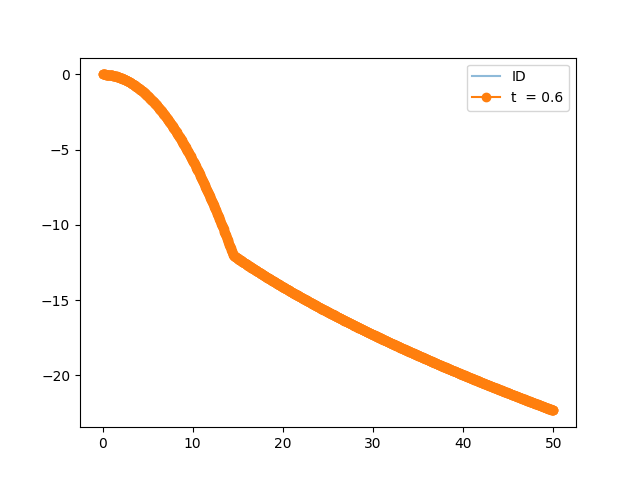

In [16]:
fig = plt.figure()

plt.plot(xs, sol[:, 0],       alpha = 0.5, label = 'ID')
plt.plot(xs, sol[:, 1], 'o-',              label = f't  = {np.round(t,2)}')

plt.legend()

# plt.ylim((-1,1))
# plt.xlim((-1, 1))